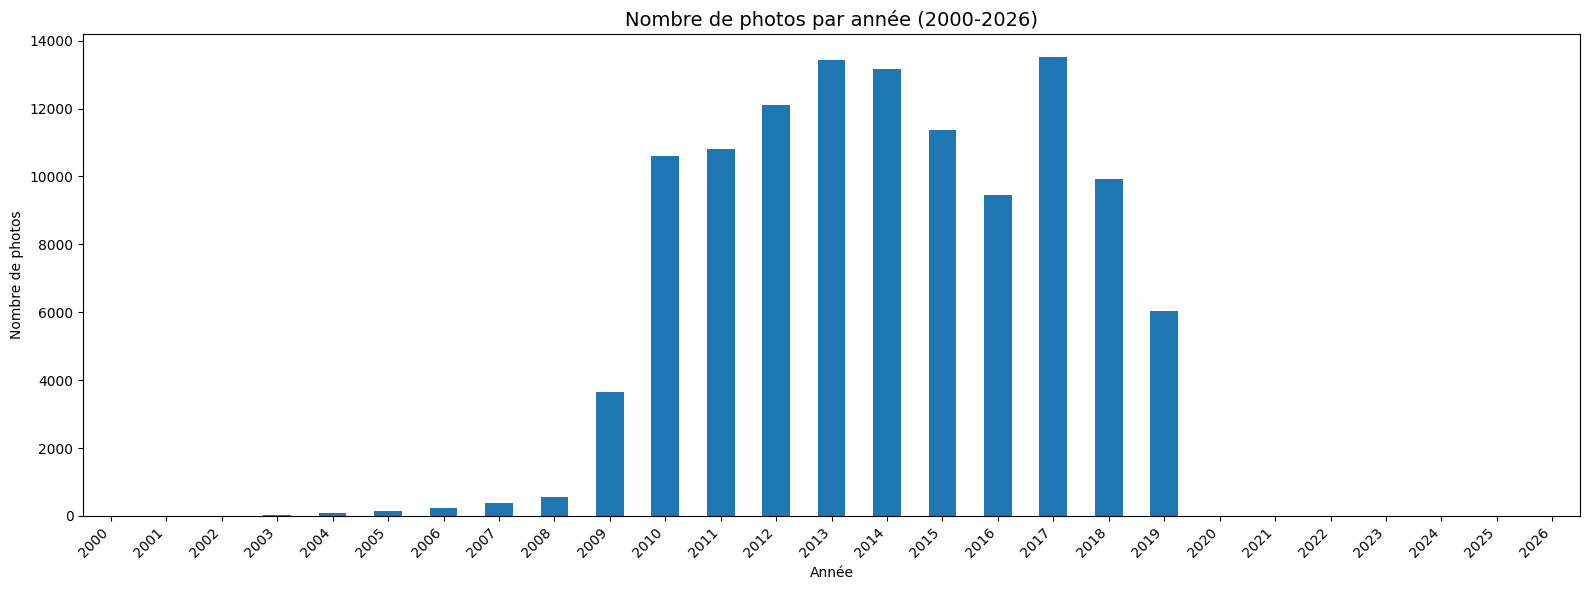

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_parquet("flickr_data_clustered.parquet")
df['year'] = pd.to_datetime(df['taken_dt']).dt.year

# Compter les photos par année
year_counts = df['year'].value_counts().sort_index()

# Créer une série complète de 2000 à 2026 (avec 0 pour les années manquantes)
all_years = pd.Series(0, index=range(2000, 2027))
all_years.update(year_counts)

# Graphique
plt.figure(figsize=(16,6))
all_years.plot(kind='bar')
plt.title("Nombre de photos par année (2000-2026)", fontsize=14)
plt.xlabel("Année")
plt.ylabel("Nombre de photos")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Pas grand chose à dire à part que les données disponibles vont jusqu'en 2019, donc il est pas possible de donner des statistiques sur des données récentes

Pour chaque cluster, on donne la tranche de temps où y a le plus de publication

 Heure de pic par cluster:

 cluster_hdbscan  peak_hour
               0         16
               1         17
               2         16
               3         19
               4         19
               5         11
               6         23
               7         14
               8         11
               9         17
              10         21
              11         15
              12         13
              13         13
              14         21
              15         13
              16         11
              17         14
              18         15
              19         17
              20         13
              21         10
              22         17
              23         17
              24         21
              25         16
              26         19
              27         15
              28         13
              29         19
              30         16
              31         11
              32         23
              33    

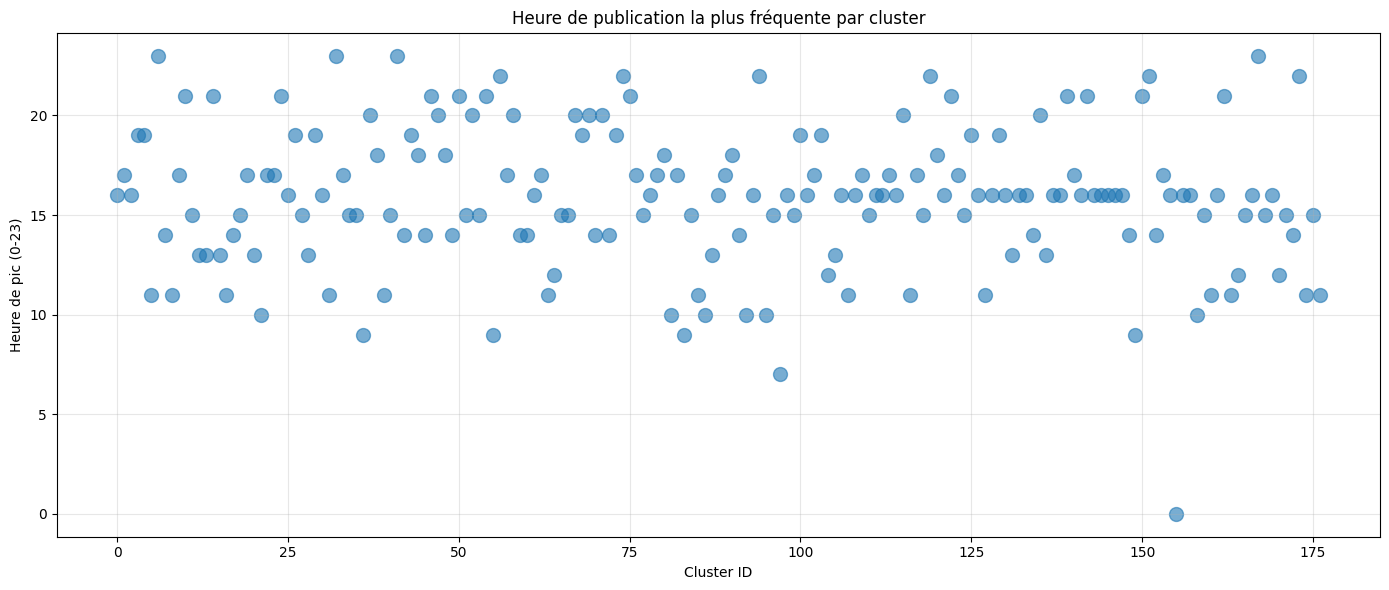

In [16]:
#l'heure de publication  
df['hour'] = pd.to_datetime(df['taken_dt']).dt.hour

# Pour chaque cluster, trouver l'heure avec le plus de publications
peak_hours = df[df['cluster_hdbscan'] != -1].groupby('cluster_hdbscan')['hour'].apply(
    lambda x: x.value_counts().idxmax()
).reset_index()

peak_hours.columns = ['cluster_hdbscan', 'peak_hour']

# Joindre avec les noms de clusters
if 'cluster_name' in df.columns:
    peak_hours = peak_hours.merge(
        df[['cluster_hdbscan', 'cluster_name']].drop_duplicates(),
        on='cluster_hdbscan'
    )
    peak_hours = peak_hours[['cluster_hdbscan', 'cluster_name', 'peak_hour']].sort_values('cluster_hdbscan')
    print("Heure de pic par cluster:\n")
    print(peak_hours.to_string(index=False))
else:
    print(" Heure de pic par cluster:\n")
    print(peak_hours.to_string(index=False))

# Visualisation
plt.figure(figsize=(14, 6))
peak_hours_sorted = peak_hours.sort_values('peak_hour')
plt.scatter(peak_hours_sorted['cluster_hdbscan'], peak_hours_sorted['peak_hour'], s=100, alpha=0.6)
plt.xlabel("Cluster ID")
plt.ylabel("Heure de pic (0-23)")
plt.title("Heure de publication la plus fréquente par cluster")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Carte interactive avec l'heure de pic pour chaque cluster

In [ ]:
import folium

# Créer un dictionnaire cluster → heure de pic
peak_hours_dict = peak_hours.set_index('cluster_hdbscan')['peak_hour'].to_dict()

# Échantillon de données pour la carte
sample = df.sample(n=min(30000, len(df)), random_state=0)

m = folium.Map(
    location=[df["lat"].median(), df["long"].median()],
    zoom_start=12,
    tiles="CartoDB positron"
)

palette = ["red", "blue", "green", "purple", "orange", "darkred", "lightred", 
           "beige", "darkblue", "darkgreen", "cadetblue", "darkpurple", 
           "pink", "lightblue", "lightgreen", "gray", "black", "lightgray"]

for _, r in sample.iterrows():
    cluster = r["cluster_hdbscan"]
    if cluster == -1:
        color = "lightgray"
    else:
        color = palette[cluster % len(palette)]
    
    # Récupérer l'heure de pic et le nom du cluster si disponible
    peak_hour = peak_hours_dict.get(cluster, 'N/A')
    cluster_name = r.get("cluster_name", "unknown") if 'cluster_name' in df.columns else "unknown"
    
    folium.CircleMarker(
        location=[r["lat"], r["long"]],
        radius=2,
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=folium.Popup(
            f"""<b>Cluster:</b> {cluster_name}<br/>
               <b>Heure pic:</b> {peak_hour}h<br/>
               <a href="{r["url"]}" target="_blank">Open Flickr</a>""",
            max_width=250
        )
    ).add_to(m)

m